## Imports & Definitions

In [ ]:
import pathlib
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
# %matplotlib widget // use qt5 as backend in jupyter notebooks for interactive plots

""" 
Install TATools via terminal with (requires Git's CLI):
`python -m pip install git+http://github.com/Potsdam-Sensors/TATools-Python.git`

or via a new notebook cell:
`!python -m pip install git+http://github.com/Potsdam-Sensors/TATools-Python.git`
"""
from TATools.processing.opera import read_folder_opera_primaryraw, read_folder_opera_secondaryraw, read_folder_opera_output
from TATools.processing import to_timestamp, read_match, re_match
from TATools.plotting.opera import *
from TATools.plotting import move_legend_outside_auto, ax_legend_segmented
from TATools.smoothing import RollingSmooth, ResampleSmooth

def read_pulses_df(fp) -> pd.DataFrame:
    df = pd.read_csv(fp)
    df['unix'] = to_timestamp(df['unix'])
    df.set_index("unix", inplace=True)

    df['indices'] = df['indices'].map(json.loads)

    df.rename(columns={
        "raw_height": "raw_pd0_height",
        "raw_side_height": "raw_pd1_height",
        "height": "pd0_height",
        "side_height": "pd1_height",
        "baseline0": "baseline_pd0",
        "baseline1": "baseline_pd1"
    }, inplace=True)
    return df

_pulses_regexp = re.compile('OPERA_(\\d|\\w+)_PrimaryRaw_(\\d{8})_Pulses(?:.raw)?.csv')
read_folder_opera_primaryraw_pulses = read_match(read_pulses_df, re_match(_pulses_regexp))

## Data Import

* `use_local_tz`: By default, some of the code converts timestamps to the host computer's timezone. Set this as `False` to instead leave the data in GMT.
* `FOLDER`: Path or relative path (to notebook) of folder containing OPERA data as `.csv`.

In [2]:
use_local_tz: bool = False

# Edit string in this call to be folder containing .csv files
FOLDER = pathlib.Path(
    "."
)

output_df = read_folder_opera_output(FOLDER)
primary_df = read_folder_opera_primaryraw(FOLDER)
secondary_df = read_folder_opera_secondaryraw(FOLDER)
pulses_df = read_folder_opera_primaryraw_pulses(FOLDER)

if not use_local_tz:
    output_df = output_df.tz_convert("GMT")
    primary_df = primary_df.reset_index(["laser", "pd0", "pd1"]).tz_convert("GMT").reset_index().set_index(["laser", "pd0", "pd1", "unix"])
    secondary_df = secondary_df.tz_convert("GMT")
    pulses_df = pulses_df.tz_convert("GMT")

## Graphs

#### OPERA Concentrations with SPS30 Concentration

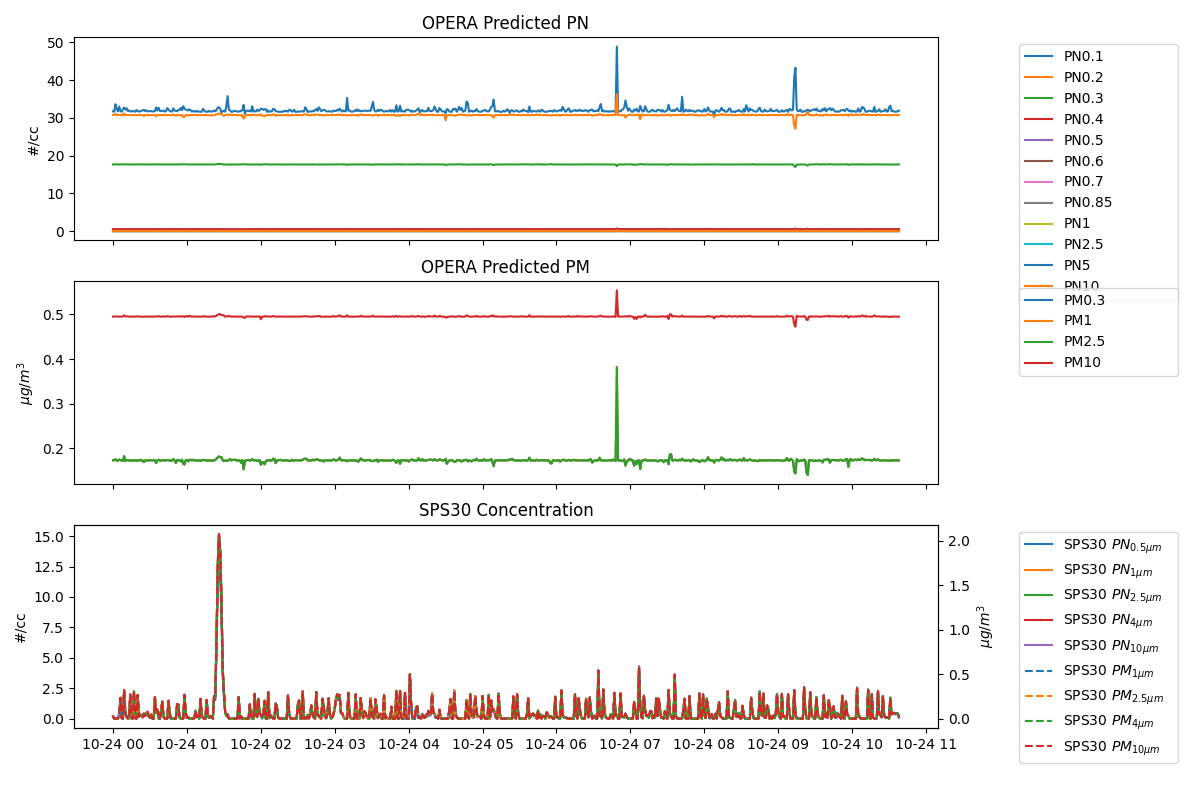

In [3]:
figsize = (12, 8)
aggregate = None
# ~ Comment the line below out to not downsample ~
aggregate = ResampleSmooth("1min", "mean")

opera_columns_pn = ['PN0.1', 'PN0.2', 'PN0.3', 'PN0.4', 'PN0.5',
                    'PN0.6', 'PN0.7', 'PN0.85', 'PN1', 'PN2.5',
                    'PN5', 'PN10']
opera_columns_pm = ['PM0.3', 'PM1', 'PM2.5', 'PM10']

sps30_columns_pn = ['sps30_pn0p5', 'sps30_pn1', 'sps30_pn2p5', 'sps30_pn4', 'sps30_pn10']
sps30_columns_pm = ['sps30_pm1', 'sps30_pm2p5', 'sps30_pm4', 'sps30_pm10']


fig, axes = plt.subplots(3,2, figsize=figsize, sharex=True, sharey=False, width_ratios=[5, 1])
opera_pn_ax, opera_pm_ax, sps30_pn_ax = axes[0][0], axes[1][0], axes[2][0]
opera_pn_leg, opera_pm_leg, sps30_leg = axes[0][1], axes[1][1], axes[2][1]
sps30_pm_ax = sps30_pn_ax.twinx()

lines_pn = []
for pn_col in opera_columns_pn:
    to_plot = output_df[pn_col]
    if aggregate: to_plot = aggregate.smooth(to_plot)

    l, = opera_pn_ax.plot(to_plot, label=pn_col)
    lines_pn.append(l)

lines_pm = []
for pm_col in opera_columns_pm:
    to_plot = output_df[pm_col]
    if aggregate: to_plot = aggregate.smooth(to_plot)

    l, = opera_pm_ax.plot(to_plot, label=pm_col)
    lines_pm.append(l)

lines_sps30 = []
for sps30_col in sps30_columns_pn:
    to_plot = secondary_df[sps30_col]
    if aggregate: to_plot = aggregate.smooth(to_plot)

    l, = sps30_pn_ax.plot(to_plot, label=var_name_or_title(sps30_col))
    lines_sps30.append(l)

for sps30_col in sps30_columns_pm:
    to_plot = secondary_df[sps30_col]
    if aggregate: to_plot = aggregate.smooth(to_plot)

    l, = sps30_pm_ax.plot(to_plot, label=var_name_or_title(sps30_col), linestyle="dashed")
    lines_sps30.append(l)



# Labeling
# leg = opera_pn_ax.legend()
# move_legend_outside_auto(opera_pn_ax, leg)
# leg = opera_pm_ax.legend()
# move_legend_outside_auto(opera_pm_ax, leg)
# leg = ax_legend_segmented(sps30_pn_ax, [lines_sps30_pm, lines_sps30_pn], ["PM", "PN"])
# move_legend_outside_auto(sps30_pn_ax, leg, pad=.03)

opera_pn_leg.set_axis_off()
opera_pn_leg.legend(handles=lines_pn, mode="expand")
opera_pm_leg.set_axis_off()
opera_pm_leg.legend(handles=lines_pm, mode="expand")
# sps30_leg.add_artist(Legend(sps30_leg, lines_pm, [x.get_label() for x in lines_pm], mode="expand"))
sps30_leg.set_axis_off()
sps30_leg.legend(handles=lines_sps30, mode="expand")


opera_pn_ax.set_title("OPERA Predicted PN")
opera_pm_ax.set_title("OPERA Predicted PM")
sps30_pn_ax.set_title("SPS30 Concentration")

opera_pn_ax.set_ylabel("#/cc")
opera_pm_ax.set_ylabel(r"$\mu g / m^3$")
sps30_pn_ax.set_ylabel("#/cc")
sps30_pm_ax.set_ylabel(r"$\mu g / m^3$")

fig.tight_layout()
fig.subplots_adjust(hspace=.2)

In [4]:
from typing import List, Tuple
def plot_stacked_class_predictions(output_df: pd.DataFrame, resample_rule="60min", title: str = "", legend_title: str = "Class Pred.", ylabel: str = "# Predictions", xlabel: str = "GMT", figsize=(16, 6),
                                   class_labels: List[str] = ['Unkwn', 'AS', 'Dust', 'Smoke'], class_colors: List[str] = ["maroon", "orange", "blue", "grey"], legend_kwargs = {},
                                   ax: plt.Axes = None) -> Tuple[plt.Figure, plt.Axes]:
    class_counts = output_df['class'].resample(rule=resample_rule).agg(lambda ser: pd.Series(dict(zip(class_labels, [ser.value_counts().to_dict().get(l) or 0 for l in class_labels]))))

    need_ax = ax is None
    if need_ax:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        fig.tight_layout()
    else:
        fig = ax.get_figure()

    ax.stackplot(class_counts.index, np.flip(np.stack(class_counts.values).transpose(), axis=0), labels=np.flip(class_labels), colors=class_colors)
    ax.legend(title=legend_title, fontsize=13, **legend_kwargs)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.tick_params(labelsize=13)
    ax.set_xlim(class_counts.index.min(), class_counts.index.max())
    ax.set_title(title or f"Class Predictions\n{resample_rule.title()} Resample", fontsize=15)
    
    if need_ax: fig.tight_layout()

    return fig, ax

(<Figure size 1200x500 with 1 Axes>,
 <Axes: title={'center': 'Class Predictions\n2Min Resample'}, xlabel='GMT', ylabel='# Predictions'>)

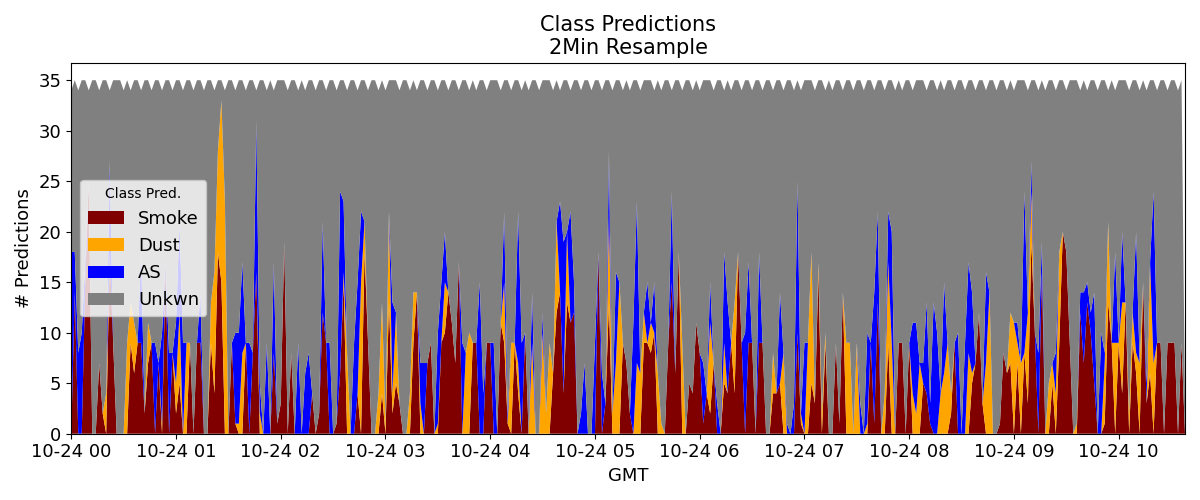

In [5]:
plot_stacked_class_predictions(output_df, resample_rule="2min", figsize=(12, 5))

#### OPERA Raw Data Concentration with SPS30 Concentration

Some variables at the top for convenience:
* `opera_var`: `str` column name to plot from OPERA
* `sps30_var`: `str` column name from `secondary_df.columns`, like `sps30_pn10`
* `figsize`: `tuple` width and height in inches for entire figure
* `aggregate`: Optional `ResampleSmooth` to reduce data points via aggregation, if desired. Otherwise comment out the second `aggregate = ` line.
    
    `ResampleSmooth` takes `window` and `agg` as args.
    * `window` is a valid `pandas.Timedelta` `str`ing like `"1min"` or `"30s"`
    * `agg` is a valid `pandas` aggregation method like `"mean"` or `"median"`

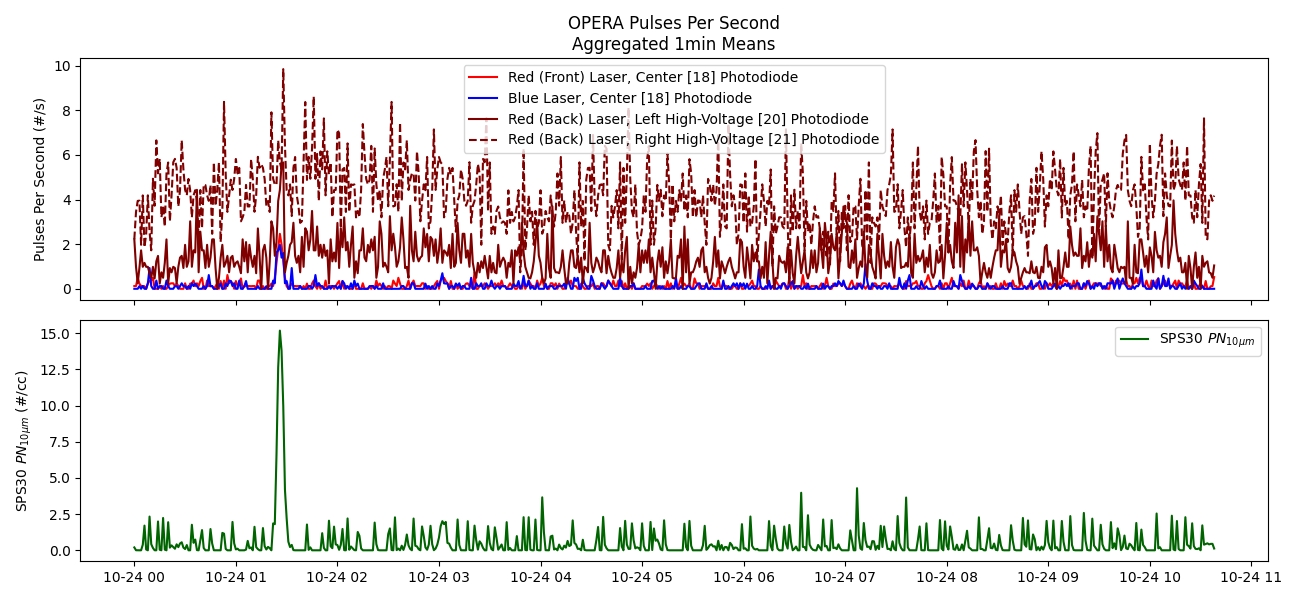

In [6]:
opera_var: str = "pulses_per_second"
sps30_var: str = "sps30_pn10"
figsize = (13, 6)
index_tuples=[(14,18),(16,18),(15,20),(15,21)]
aggregate = None
# ~ Comment the line below out to not downsample ~
aggregate = ResampleSmooth("1min", "mean")

fig, (opera_ax, sps30_ax) = plt.subplots(2,1, figsize=figsize, sharex=True, sharey=False)

# Plot OPERA Data
d = primary_df.droplevel("pd1")[[opera_var]] # temp copy, indexed without pd1
for laser, pd0 in index_tuples:
    to_plot = d.loc[laser, pd0][opera_var].tz_convert("GMT")
    if aggregate is not None:
        to_plot = aggregate.smooth(to_plot)
    opera_ax.plot(
        to_plot,
        color=LASER_COLOR_MAP.get(laser),
        linestyle=PD0_STYLE_MAP.get(pd0),
        label=laser_and_photodiode(laser, pd0)
    )

# Plot SPS30 Data
to_plot = secondary_df[sps30_var]
if aggregate:
    to_plot = aggregate.smooth(to_plot)
sps30_ax.plot(to_plot, label=var_name_or_title(sps30_var), color="darkgreen")


# Labeling
opera_ax.legend()
sps30_ax.legend()

opera_ax.set_ylabel(var_name_and_units(opera_var))
sps30_ax.set_ylabel(var_name_and_units(sps30_var))

title = f"OPERA {var_name_or_title(opera_var)}"
if aggregate: title += f"\n{aggregate.label()}"
opera_ax.set_title(title)

# del d
fig.tight_layout()